In [10]:
import numpy as np
import pandas as pd
import geopandas as gpd
import json
import requests
import rasterio
from shapely.ops import cascaded_union
from shapely.geometry import Point
from rasterstats import zonal_stats
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
%matplotlib inline 

***

** FSP maps **

In [2]:
fsp_maps = pd.read_csv('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/FSP_Maps/FSP_maps.csv')

In [3]:
fsp_maps.head()

,Unnamed: 0,id,sector,type,land_use,iso,country,lat,lng,year
0,0,0,Agriculture,Agro-dealers,Rural,IND,India,25.56872,84.67436,2014
1,1,1,Agriculture,Agro-dealers,Rural,IND,India,26.91513,83.43577,2014
2,2,2,Agriculture,Agro-dealers,Rural,IND,India,26.16912,84.04030,2014
3,3,3,Agriculture,Agro-dealers,Rural,IND,India,26.67519,83.22662,2014
4,4,4,Agriculture,Agro-dealers,Rural,IND,India,26.67521,83.22684,2014


In [4]:
fsp_maps['geometry'] = fsp_maps.apply(lambda x: Point(x.lng, x.lat), axis=1)

In [5]:
fsp_maps.head()

,Unnamed: 0,id,sector,type,land_use,iso,country,lat,lng,year,geometry
0,0,0,Agriculture,Agro-dealers,Rural,IND,India,25.56872,84.67436,2014,POINT (84.67435999999999 25.56872)
1,1,1,Agriculture,Agro-dealers,Rural,IND,India,26.91513,83.43577,2014,POINT (83.43576999999999 26.91513)
2,2,2,Agriculture,Agro-dealers,Rural,IND,India,26.16912,84.04030,2014,POINT (84.0403 26.16912)
3,3,3,Agriculture,Agro-dealers,Rural,IND,India,26.67519,83.22662,2014,POINT (83.22662 26.67519)
4,4,4,Agriculture,Agro-dealers,Rural,IND,India,26.67521,83.22684,2014,POINT (83.22684 26.67521)


In [6]:
fsp_maps = gpd.GeoDataFrame(fsp_maps)

** Population 2015 **

In [7]:
input_raster  = "/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/cartodb/population_count_2015.tif"
with rasterio.open(input_raster) as modisData:
    profile = modisData.profile
    population = modisData.read()

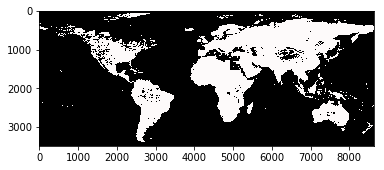

In [8]:
plt.imshow(population[0],interpolation=None, cmap=cm.gist_earth)

### Read country maps

** India **

In [9]:
indMap = gpd.read_file('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/gadm36_shp/gadm36_IND.shp')
# Get Uttar Pradesh and Bihar states
indMapStates = indMap[(indMap['NAME_1'] == 'Uttar Pradesh') | (indMap['NAME_1'] == 'Bihar')]

** Kenya **

In [10]:
kenMap = gpd.read_file('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/gadm36_shp/gadm36_KEN.shp')

** Uganda **

In [11]:
ugaMap = gpd.read_file('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/gadm36_shp/gadm36_UGA.shp')

** Bangladesh **

In [12]:
bgdMap = gpd.read_file('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/gadm36_shp/gadm36_BGD.shp')

** Nigeria **

In [13]:
ngaMap = gpd.read_file('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/gadm36_shp/gadm36_NGA.shp')

** Tanzania **

In [14]:
tzaMap = gpd.read_file('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/gadm36_shp/gadm36_TZA.shp')

Get the boundary of each country

In [57]:
indBoundary = gpd.GeoSeries(cascaded_union(indMapStates['geometry']))
indBoundary = gpd.GeoDataFrame(indBoundary).rename(columns={0: 'geometry'})
indBoundary['country'] = 'India'
indBoundary['iso'] = 'IND'

kenBoundary = gpd.GeoSeries(cascaded_union(kenMap['geometry']))
kenBoundary = gpd.GeoDataFrame(kenBoundary).rename(columns={0: 'geometry'})
kenBoundary['country'] = 'Kenya'
kenBoundary['iso'] = 'KEN'

ugaBoundary = gpd.GeoSeries(cascaded_union(ugaMap['geometry']))
ugaBoundary = gpd.GeoDataFrame(ugaBoundary).rename(columns={0: 'geometry'})
ugaBoundary['country'] = 'Uganda'
ugaBoundary['iso'] = 'UGA'

bgdBoundary = gpd.GeoSeries(cascaded_union(bgdMap['geometry']))
bgdBoundary = gpd.GeoDataFrame(bgdBoundary).rename(columns={0: 'geometry'})
bgdBoundary['country'] = 'Bangladesh'
bgdBoundary['iso'] = 'BGD'

ngaBoundary = gpd.GeoSeries(cascaded_union(ngaMap['geometry']))
ngaBoundary = gpd.GeoDataFrame(ngaBoundary).rename(columns={0: 'geometry'})
ngaBoundary['country'] = 'Nigeria'
ngaBoundary['iso'] = 'NGA'

tzaBoundary = gpd.GeoSeries(cascaded_union(tzaMap['geometry']))
tzaBoundary = gpd.GeoDataFrame(tzaBoundary).rename(columns={0: 'geometry'})
tzaBoundary['country'] = 'Tanzania'
tzaBoundary['iso'] = 'TZA'

boundaries = gpd.GeoDataFrame(pd.concat([indBoundary,kenBoundary,ugaBoundary,bgdBoundary,ngaBoundary,tzaBoundary]))

In [16]:
#Setting a Projection
boundaries.crs  = {'init': 'epsg:4326'}

### Total population within 5 km of all access points in a country

In [126]:
gdf = gpd.GeoDataFrame(columns=['geometry', 'iso','sum'])

for country in ['IND','KEN','UGA','BGD','NGA','TZA']:
    bor = boundaries[boundaries['iso'] == country]
    fsp = fsp_maps[fsp_maps['iso'] == country]

    #Setting a Projection
    bor.crs  = {'init': 'epsg:4326'}
    fsp.crs  = {'init': 'epsg:4326'}
    #Re-Projecting
    bor = bor.to_crs({'init': 'epsg:3857'})
    fsp = fsp.to_crs({'init': 'epsg:3857'})
    
    # Make a buffer of 5 km
    buffer_area = fsp.geometry.buffer(5000).unary_union
    buffer_border = gpd.GeoDataFrame({'geometry': [buffer_area]})
    buffer_border = gpd.GeoSeries(cascaded_union(buffer_border['geometry']))
    buffer_border = gpd.GeoDataFrame({'geometry': buffer_border, 'iso': country})
    
    # Intersect with country boundary
    buffer_border = gpd.overlay(gpd.GeoDataFrame(buffer_border), bor, how='intersection')
    # cascade union
    buffer_border = gpd.GeoSeries(cascaded_union(buffer_border['geometry']))
    buffer_border = gpd.GeoDataFrame(buffer_border).rename(columns={0: 'geometry'})
    buffer_border['iso'] = country 
    
    #Setting a Projection
    bor.crs  = {'init': 'epsg:3857'}
    buffer_border.crs  = {'init': 'epsg:3857'}
    #Re-Projecting
    bor = bor.to_crs({'init': 'epsg:4326'})
    buffer_border = buffer_border.to_crs({'init': 'epsg:4326'})
    
    # Total population within 5 km of all access points in a country
    zs = zonal_stats(buffer_border, '/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/cartodb/population_count_2015.tif',  all_touched=True, stats='sum')
    zs = gpd.GeoDataFrame(zs)
    zs['iso'] = country
    
    buffer_border = pd.merge(buffer_border, zs, how='left', on='iso')
    
    gdf = pd.concat([gdf,buffer_border])

/anaconda3/lib/python3.6/site-packages/rasterstats/main.py:145: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
/anaconda3/lib/python3.6/site-packages/rasterstats/io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)
/anaconda3/lib/python3.6/site-packages/rasterstats/main.py:165: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  np.issubdtype(fsrc.array.dtype, float)


In [128]:
gdf.rename(columns = {'sum': 'total_population'}, inplace=True)

In [129]:
gdf.head()

,geometry,iso,total_population
0,(POLYGON ((83.09238036693706 23.87984986098025...,IND,333512448.0
0,(POLYGON ((39.40680694999998 -4.68319416000001...,KEN,39716328.0
0,"(POLYGON ((31.0383721523553 1.399679440290742,...",UGA,37612828.0
0,(POLYGON ((89.02469757081434 22.29407930006235...,BGD,155739600.0
0,(POLYGON ((6.206747372737611 4.279860019999984...,NGA,100723936.0


Save table

In [130]:
gdf.to_csv('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/cartodb/population_within_5km.csv')

** Example Uganda **

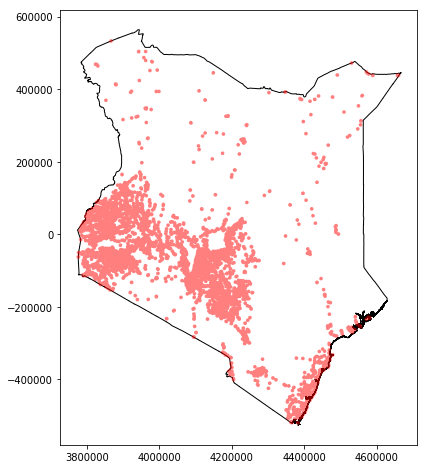

In [110]:
bor = boundaries[boundaries['iso'] == 'KEN']
fsp = fsp_maps[fsp_maps['iso'] == 'KEN']

#Setting a Projection
bor.crs  = {'init': 'epsg:4326'}
fsp.crs  = {'init': 'epsg:4326'}
#Re-Projecting
bor = bor.to_crs({'init': 'epsg:3857'})
fsp = fsp.to_crs({'init': 'epsg:3857'})
    
# Make a buffer of 5 km
buffer_area = fsp.geometry.buffer(5000).unary_union
buffer_border = gpd.GeoDataFrame({'geometry': [buffer_area]})
buffer_border = gpd.GeoSeries(cascaded_union(buffer_border['geometry']))
buffer_border = gpd.GeoDataFrame({'geometry': buffer_border, 'iso': 'KEN'})

# Plot
fig, ax = plt.subplots(figsize=[8,8])
ax.set_aspect('equal')

bor.plot(ax=ax, color='white', edgecolor='black')
buffer_border.plot(ax=ax, color='red', alpha=0.5)

In [111]:
buffer_border

,geometry,iso
0,(POLYGON ((4382842.669565889 -525105.981995245...,KEN


In [112]:
buffer_border = gpd.overlay(gpd.GeoDataFrame(buffer_border), bor, how='intersection')

In [113]:
buffer_border.head()

,iso,country,iso_2,geometry
0,KEN,Kenya,KEN,POLYGON ((4386745.683462832 -521912.2592482902...
1,KEN,Kenya,KEN,"POLYGON ((4457346.966480892 177995.5309164356,..."
2,KEN,Kenya,KEN,"POLYGON ((4445517.789820064 187764.0963276844,..."
3,KEN,Kenya,KEN,"POLYGON ((4210735.556057254 172644.172339822, ..."
4,KEN,Kenya,KEN,"POLYGON ((3862571.788266908 531042.9607623554,..."


In [114]:
buffer_border = gpd.GeoSeries(cascaded_union(buffer_border['geometry']))
buffer_border = gpd.GeoDataFrame(buffer_border).rename(columns={0: 'geometry'})
buffer_border['iso'] = 'KEN' 

In [115]:
buffer_border

,geometry,iso
0,(POLYGON ((4386745.683462832 -521912.259248290...,KEN


In [117]:
buffer_border.crs  = {'init': 'epsg:4326'}

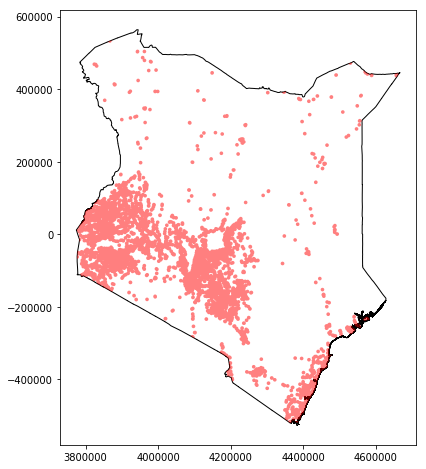

In [118]:
# Plot
fig, ax = plt.subplots(figsize=[8,8])
ax.set_aspect('equal')

bor.plot(ax=ax, color='white', edgecolor='black')
buffer_border.plot(ax=ax, color='red', alpha=0.5)

In [119]:
#Setting a Projection
bor.crs  = {'init': 'epsg:3857'}
buffer_border.crs  = {'init': 'epsg:3857'}
#Re-Projecting
bor = bor.to_crs({'init': 'epsg:4326'})
buffer_border = buffer_border.to_crs({'init': 'epsg:4326'})

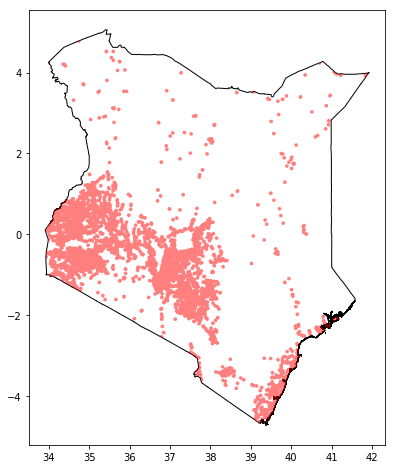

In [120]:
# Plot
fig, ax = plt.subplots(figsize=[8,8])
ax.set_aspect('equal')

bor.plot(ax=ax, color='white', edgecolor='black')
buffer_border.plot(ax=ax, color='red', alpha=0.5)

In [124]:
# Total population within 5 km of all access points in a country
zs = zonal_stats(bor, '/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/cartodb/population_count_2015.tif',  all_touched=True, stats='sum')
zs = gpd.GeoDataFrame(zs)
zs['iso'] = country
    
buffer_border = pd.merge(buffer_border, zs, how='left', on='iso')

/anaconda3/lib/python3.6/site-packages/rasterstats/main.py:145: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
/anaconda3/lib/python3.6/site-packages/rasterstats/io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)
/anaconda3/lib/python3.6/site-packages/rasterstats/main.py:165: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  np.issubdtype(fsrc.array.dtype, float)


In [125]:
buffer_border

,geometry,iso,sum_x,sum_y
0,(POLYGON ((39.40680694999998 -4.68319416000001...,KEN,NaN,NaN


In [123]:
bor 

,geometry,country,iso
0,(POLYGON ((39.37625121999998 -4.71569394999999...,Kenya,KEN


***

# layer_spec

In [3]:
df_layer = pd.DataFrame(columns = ['provider', 'dataset', 'dataset_id', 'layer', 'layer_id', 'queries', 'css', 'legend_config'])

In [4]:
df_layer

,provider,dataset,dataset_id,layer,layer_id,queries,css,legend_config


** cartodb **

In [ ]:
provider = ['cartodb'] * 6
dataset = ['AidData', 'Electrical Grid', 'Mobile Coverage', 'Mobile Coverage', 'Mobile Coverage', 'Urban Areas']
dataset_id = [''] * 6
layer = ['AidData', 'Electrical Grid', 'Global GSM', 'Global 3G', 'Global 4G', 'Urban Areas']
layer_id = [''] * 6
queries = ['SELECT the_geom, the_geom_webmercator, sum(transaction_value) as total_transaction_value FROM aiddata_transactions GROUP BY the_geom, the_geom_webmercator',
           'SELECT the_geom, the_geom_webmercator FROM electrical_grid',
           'SELECT the_geom, the_geom_webmercator FROM mobile_coverage_global_gsm',
           'SELECT the_geom, the_geom_webmercator FROM mobile_coverage_global_3g',
           'SELECT the_geom, the_geom_webmercator FROM mobile_coverage_global_4g',
           'SELECT the_geom, the_geom_webmercator FROM urban_areas']
css = ['#layer {marker-width: ramp([total_transaction_value], range(2, 20), quantiles(5)); marker-fill: ramp([total_transaction_value], (#009392, #71be83, #e9e29c, #ed9c72, #cf597e), quantiles); marker-fill-opacity: 1; marker-allow-overlap: true; marker-line-width: 1; marker-line-color: #FFFFFF; marker-line-opacity: 1;}',
      '#layer {line-width: 2; line-color: #4CC8A3; line-opacity: 1;}',
       '#layer {polygon-fill: #826dba; polygon-opacity: 0.9;} #layer::outline {line-width: 1; line-color: #FFFFFF;line-opacity: 0.5;}',
       '#layer {polygon-fill: #826dba; polygon-opacity: 0.9;} #layer::outline {line-width: 1; line-color: #FFFFFF;line-opacity: 0.5;}',
       '#layer {polygon-fill: #826dba; polygon-opacity: 0.9;} #layer::outline {line-width: 1; line-color: #FFFFFF;line-opacity: 0.5;}',
       '#layer {polygon-fill: #826DBA; polygon-opacity: 0.9; ::outline {line-color: #FFFFFF; line-width: 1; line-opacity: 0.5; } }'] 

legend_config = [json.dumps({'legendConfig': {'items': [{'color': '#009392'},
      {'color': '#71be83'},
      {'color': '#e9e29c'},
      {'color': '#ed9c72'},
      {'color': '#cf597e'}],
      'sql_config': [{'key': 'where',
       'key_params': [{'key': 'iso_a3', 'required': False}]}],
      'sql_query': 'with r as (SELECT the_geom, sum(transaction_value) as total_transaction_value  FROM aiddata_transactions {{where}} GROUP BY the_geom) SELECT CDB_JenksBins(array_agg(total_transaction_value::numeric),5) as bucket FROM r WHERE total_transaction_value is not null',
      'type': 'choropleth'}}),
                 json.dumps({'legendConfig': {'items': [{'color': '#4CC8A3', 'name': 'Electrical Grid'}],
                                              'type': 'basic'}}),       
                 json.dumps({'legendConfig': {'items': [{'color': '#da4e3c', 'name': 'GSM mobile coverage'}],
     'type': 'basic'}}),
                 json.dumps({'legendConfig': {'items': [{'color': '#fcaa0f', 'name': '3G mobile coverage'}],
     'type': 'basic'}}),
                 json.dumps({'legendConfig': {'items': [{'color': '#f9c932', 'name': '4G mobile coverage'}],
     'type': 'basic'}}),
                 json.dumps({'legendConfig': {'items': [{'color': '#826DBA', 'name': 'Urban Area'}],
     'type': 'basic'}})
]

data = {'provider': provider, 'dataset': dataset, 'dataset_id': dataset_id, 
        'layer': layer, 'layer_id': layer_id,  'queries': queries, 'css': css, 'legend_config': legend_config}

df_layer = pd.concat([df_layer,pd.DataFrame(data)], join='inner')

** RW API **

In [8]:
provider = ['rw_api'] * 12
dataset = ['Accessibility to Cities', 'Population (Grid, 1 km)', 'Urban Built-Up Area', 
           'Agricultural Exposure to Water Stress', 'Erosion Risk', 'Annual Precipitation',
          'Aridity', 'Roads', 'Roadless Areas', 'Current Water Risk', 
           'Reservoirs and Dams', 'Reservoirs and Dams']
dataset_id = ['ccbcaf7b-1619-4298-8275-b135d1e8e04e', '595bcf6f-0343-4146-ba0d-c54b1c928510',
             'f6bb99af-541a-4d41-9e47-cc36cb479d4b', '05c330d7-49cf-42d6-bada-e255b8c8e115',
             'e6e83d98-aa1f-495f-916c-b33d0657e0fe', '12510410-1eb3-4af0-844f-8a05be50b1c1',
             '99075509-df36-461e-abb0-659cee555bd0', '943f3702-421f-47a4-9b99-e2d5a9f544a7',
             'a07f1bed-ca16-4fbf-b14b-d3a0344cab74', 'd7c3d954-ac86-4d1a-bb6a-c8c432a94e26',
             'e63bb157-4b98-4ecb-81d6-c1b15e79895a', 'e63bb157-4b98-4ecb-81d6-c1b15e79895a']
layer = ['Accessibility to Cities', 'Population (Grid, 1 km)', 'Urban Built-Up Area', 
           'Agricultural Exposure to Water Stress', 'Erosion Risk', 'Annual Precipitation',
          'Aridity', 'Roads', 'Roadless Areas', 'Current Water Risk', 
           'Reservoirs', 'Dams']
layer_id = ['d787d894-f7af-47c4-af0f-0849b06686ee', '478468be-c79f-4472-b910-594f5bb67cf1',
           'b1223c4f-7132-42d3-a1cd-90e823adaa5f', '05c330d7-49cf-42d6-bada-e255b8c8e115',
           '829f01de-d659-4c6f-bdad-74c79f6451ca', '47835c64-6934-439f-8750-9e3f23debf5c',
           'ca3293ef-63f5-462b-ac28-41e82aac21bf', '72bd4541-89d4-467d-905d-dc745511e2cc',
           'a07f1bed-ca16-4fbf-b14b-d3a0344cab74', '2db606de-49d9-49d4-a6ef-6f45b6d0cf04',
           '212a1516-c7d5-44aa-a18a-ab8bc99929e7', '6528a5e5-c4cc-49b1-a603-b9ee90b644f7']
queries = [''] * 12
css = [''] * 12
legeng_config = [''] * 12

data = {'provider': provider, 'dataset': dataset, 'dataset_id': dataset_id, 
        'layer': layer, 'layer_id': layer_id,  'queries': queries, 'css': css, 'legeng_config':legeng_config}

#df_layer = pd.concat([df_layer,pd.DataFrame(data)], join='inner')
df_layer = pd.concat([df_layer,pd.DataFrame(data)])

df_layer.reset_index(inplace=True, drop=True)
df_layer = df_layer[['provider', 'dataset', 'dataset_id', 'layer', 'layer_id', 'queries', 'css', 'legend_config']]

** Add dataset slug to table **

In [11]:
slug_list =[]
for i in range(len(df_layer)):
    if df_layer['dataset_id'][i] != '':
        dataset_id = df_layer['dataset_id'][i]
        url = "http://api.resourcewatch.org/v1/dataset/"+dataset_id
        r = requests.get(f"{url}")
        slug = r.json().get('data').get('attributes').get('slug')
    else:
        slug =''
    slug_list.append(slug)

In [12]:
df_layer['slug'] = slug_list

### Add type_id column

In [110]:
df_layer['type_id'] = np.arange(len(df_layer))+131

In [111]:
df_layer

,provider,dataset,dataset_id,layer,layer_id,queries,css,legend_config,slug,type_id
0,cartodb,AidData,,AidData,,"SELECT the_geom, the_geom_webmercator, sum(tra...",#layer {marker-width: ramp([total_transaction_...,"{""legendConfig"": {""items"": [{""color"": ""#009392...",,131
1,cartodb,Electrical Grid,,Electrical Grid,,"SELECT the_geom, the_geom_webmercator FROM ele...",#layer {line-width: 2; line-color: #4CC8A3; li...,"{""legendConfig"": {""items"": [{""color"": ""#4CC8A3...",,132
2,cartodb,Mobile Coverage,,Global GSM,,"SELECT the_geom, the_geom_webmercator FROM mob...",#layer {polygon-fill: #826dba; polygon-opacity...,"{""legendConfig"": {""items"": [{""color"": ""#da4e3c...",,133
3,cartodb,Mobile Coverage,,Global 3G,,"SELECT the_geom, the_geom_webmercator FROM mob...",#layer {polygon-fill: #826dba; polygon-opacity...,"{""legendConfig"": {""items"": [{""color"": ""#fcaa0f...",,134
4,cartodb,Mobile Coverage,,Global 4G,,"SELECT the_geom, the_geom_webmercator FROM mob...",#layer {polygon-fill: #826dba; polygon-opacity...,"{""legendConfig"": {""items"": [{""color"": ""#f9c932...",,135
5,cartodb,Urban Areas,,Urban Areas,,"SELECT the_geom, the_geom_webmercator FROM urb...",#layer {polygon-fill: #826DBA; polygon-opacity...,"{""legendConfig"": {""items"": [{""color"": ""#826DBA...",,136
6,rw_api,Accessibility to Cities,ccbcaf7b-1619-4298-8275-b135d1e8e04e,Accessibility to Cities,d787d894-f7af-47c4-af0f-0849b06686ee,,,NaN,cit01701-Travel-Time-to-Major-Cities,137
7,rw_api,"Population (Grid, 1 km)",595bcf6f-0343-4146-ba0d-c54b1c928510,"Population (Grid, 1 km)",478468be-c79f-4472-b910-594f5bb67cf1,,,NaN,soc072-Population-Grid-250-m,138
8,rw_api,Urban Built-Up Area,f6bb99af-541a-4d41-9e47-cc36cb479d4b,Urban Built-Up Area,b1223c4f-7132-42d3-a1cd-90e823adaa5f,,,NaN,Cit014-Built-Up-Grid,139
9,rw_api,Agricultural Exposure to Water Stress,05c330d7-49cf-42d6-bada-e255b8c8e115,Agricultural Exposure to Water Stress,05c330d7-49cf-42d6-bada-e255b8c8e115,,,NaN,Global-growing-crops-under-high-water-stress-c...,140


Save table

In [113]:
df_layer.to_csv('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/cartodb/layer_spec.csv')

** Change table column type to json directly in carto **

ALTER TABLE layer_spec
ALTER COLUMN layer_config TYPE jsonb USING layer_config::JSONB

***

# contextual_spec

In [14]:
df_contex = pd.DataFrame(columns = ['provider', 'dataset', 'dataset_id', 'layer', 'layer_id'])

In [15]:
df_contex

,provider,dataset,dataset_id,layer,layer_id


In [94]:
provider = ['RW API'] * 16
dataset = ['Access to Electricity', 'Access to Electricity', 'Access to Electricity',
          'Adult Literacy Rate', 'Child Malnutrition', 'Child Malnutrition', 'Child Malnutrition',
          'Child Malnutrition', 'Child Malnutrition', 'Current Account Balance', 
          'Gender Development Index', 'Gender Inequality Index', 'Gross Domestic Product',
          'Regulatory Restrictiveness Index', 'Urban Population Living in Slums',
          'Vulnerability to Climate Change Index']
dataset_id = ['d446a52e-c4c1-4e74-ae30-3204620a0365', 'd446a52e-c4c1-4e74-ae30-3204620a0365',
             'd446a52e-c4c1-4e74-ae30-3204620a0365', 'e8f53f73-d77c-485a-a2a6-1c47ea4aead9',
             '8bc79a36-d77e-4ee3-b9bc-c77146cfc503', '8bc79a36-d77e-4ee3-b9bc-c77146cfc503',
             '8bc79a36-d77e-4ee3-b9bc-c77146cfc503', '8bc79a36-d77e-4ee3-b9bc-c77146cfc503',
             '8bc79a36-d77e-4ee3-b9bc-c77146cfc503', '2e31a1f3-576b-46b4-84f0-3f0cc399f887',
             'd4ca3cc4-c162-469c-b341-b52284a73eaa', '11278cb6-b298-49a1-bf71-f1e269f40758',
             '52c55378-0484-48c3-92fc-3ee94d21c716', 'fe311144-8c0e-4440-b068-6efd057e0f6a',
             '35ce2b98-adbb-4873-b334-d7b1cc542de7', 'fa6443ff-eb95-4d0f-84d2-f0c91682efdf']
layer = ['National Access to Electricity', 'Rural Access to Electricity',
        'Urban Access to Electricity', 'Adult Literacy Rate', 'Children Under 5 Severely Wasting',
        'Children Under 5 Stunting', 'Children Under 5 Underweight', 'Children Under 5 Wasting',
        'Children Under 5 Overweight', 'Current Account Balance', 'Gender Development Index',
        'Gender Inequality Index', 'Gross Domestic Product', 'Regulatory Restrictiveness Index',
        'Urban Population Living in Slums', 'Vulnerability to Climate Change Index']
layer_id = ['3369edc2-4537-44eb-979e-fb9b573d1493', 'd4404f80-c2d3-479d-b19c-749a8f6e2696',
           'a0e3f05d-3b0a-44d1-8114-7e9e9e2b65f9', 'c43b7d21-1e0a-4257-8618-b5a356e06530',
           'ce22f648-c965-4458-a801-2c58a4f69fac', 'bea1db0e-b99d-454b-bddd-c7cabd2e6b27',
           '55721450-ce51-4f60-b7c8-416d74a1ad6c', '29edd41b-8f0b-43b5-a0fe-17cd68f8832d',
           '65b778e8-6050-49ad-b9d1-dc4cb7c1ae59', 'e94efe26-7801-409f-9d24-90c2a652cf83',
           '3ff24d05-7a38-49d3-a14a-cec86a29578d', '9d3ef845-93a1-47a0-b26a-c124b8a6ff2b',
           'f98f8874-3d5d-4818-a75c-29a8d1b57cb3', '998035d6-2d5f-4876-ba6c-e7443db3afa8',
           'ad704eea-4ef5-455c-b7ae-ad5bab572e0c', '07b6e469-d1c4-4ab8-a8a7-cf37f344ae4c']

In [17]:
data = {'provider': provider, 'dataset': dataset, 'dataset_id': dataset_id, 
        'layer': layer, 'layer_id': layer_id}

df_contex = pd.concat([df_contex,pd.DataFrame(data)], join='inner')

df_contex.reset_index(inplace=True, drop=True)

In [114]:
df_contex

,provider,dataset,dataset_id,layer,layer_id
0,RW API,Access to Electricity,d446a52e-c4c1-4e74-ae30-3204620a0365,National Access to Electricity,3369edc2-4537-44eb-979e-fb9b573d1493
1,RW API,Access to Electricity,d446a52e-c4c1-4e74-ae30-3204620a0365,Rural Access to Electricity,d4404f80-c2d3-479d-b19c-749a8f6e2696
2,RW API,Access to Electricity,d446a52e-c4c1-4e74-ae30-3204620a0365,Urban Access to Electricity,a0e3f05d-3b0a-44d1-8114-7e9e9e2b65f9
3,RW API,Adult Literacy Rate,e8f53f73-d77c-485a-a2a6-1c47ea4aead9,Adult Literacy Rate,c43b7d21-1e0a-4257-8618-b5a356e06530
4,RW API,Child Malnutrition,8bc79a36-d77e-4ee3-b9bc-c77146cfc503,Children Under 5 Severely Wasting,ce22f648-c965-4458-a801-2c58a4f69fac
5,RW API,Child Malnutrition,8bc79a36-d77e-4ee3-b9bc-c77146cfc503,Children Under 5 Stunting,bea1db0e-b99d-454b-bddd-c7cabd2e6b27
6,RW API,Child Malnutrition,8bc79a36-d77e-4ee3-b9bc-c77146cfc503,Children Under 5 Underweight,55721450-ce51-4f60-b7c8-416d74a1ad6c
7,RW API,Child Malnutrition,8bc79a36-d77e-4ee3-b9bc-c77146cfc503,Children Under 5 Wasting,29edd41b-8f0b-43b5-a0fe-17cd68f8832d
8,RW API,Child Malnutrition,8bc79a36-d77e-4ee3-b9bc-c77146cfc503,Children Under 5 Overweight,65b778e8-6050-49ad-b9d1-dc4cb7c1ae59
9,RW API,Current Account Balance,2e31a1f3-576b-46b4-84f0-3f0cc399f887,Current Account Balance,e94efe26-7801-409f-9d24-90c2a652cf83


Save table

In [115]:
df_contex.to_csv('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/cartodb/contextual_spec.csv')

***

# widget_spec

In [102]:
df_widget = pd.DataFrame(columns = ['provider', 'data_type', 'dataset', 'analysis_name', 'analysis_type', 'output', 'widget_config'])

In [103]:
df_widget

,provider,data_type,dataset,analysis_name,analysis_type,output,widget_config


** FSP_maps **

In [104]:
provider = ['cartodb'] * 9
data_type = ['FSP_map'] * 9
dataset = ['FSP_map'] * 9
analysis_name = ['Access points and population', 'Access points and population', 'Number of services', 'Number of services',
       'Access points percentage', 'Access points percentage', 'Distance to access points', 'Distance to access points', 'Distance to access points']
analysis_type = ['polygon', 'country', 'polygon', 'country', 'polygon', 'country', 'polygon_nearby', 'polygon_area', 'country']
output = ['number', 'number', 'chart', 'chart', 'chart', 'chart', 'chart', 'chart', 'chart']
widget_config = ['{"widgetConfig": {"params_config": [{"required": true, "key": "account"}, {"required": true, "key": "geojson"}, {"required": true, "key": "type_ids"}], "sql_query": "https://{{account}}.carto.com/api/v2/sql?q=WITH b as (SELECT st_setsrid(st_geomfromgeojson({{geojson}}),4326) as the_geom), u as (SELECT ST_Intersection(u.the_geom,b.the_geom) as the_geom FROM urban_areas as u, b WHERE ST_Intersects(u.the_geom, b.the_geom)) SELECT points.count as access_points, tot.pop as total_population, COALESCE(urb.pop, tot.pop) as urban_population, round(((COALESCE(urb.pop, tot.pop)/tot.pop)*100)::numeric, 1) as urban_population_percentage, (tot.pop - COALESCE(urb.pop, tot.pop)) as rural_population, round((((tot.pop - COALESCE(urb.pop, tot.pop))/tot.pop)*100)::numeric,1) as rural_population_percentage FROM (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, b.the_geom),1,True)).sum) as pop FROM population_count_2015, b WHERE ST_Intersects(the_raster_webmercator, b.the_geom)) as tot, (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, u.the_geom),1,True)).sum) as pop FROM population_count_2015, u WHERE ST_Intersects(the_raster_webmercator, u.the_geom)) as urb, (SELECT count(*) FROM fsp_maps as m, b WHERE ST_Intersects(m.the_geom, b.the_geom) and type_id in {{type_ids}}) as points", "type": "text"}}',
                 '{"widgetConfig": {"params_config": [{"required": true, "key": "account"}, {"required": true, "key": "type_ids"}, {"required": true, "key": "iso"}], "sql_query": "https://{{account}}.carto.com/api/v2/sql?q=WITH b as (SELECT the_geom FROM world_borders_hd as b WHERE b.iso_a3 = {{iso}}), u as (SELECT ST_Intersection(u.the_geom,b.the_geom) as the_geom FROM urban_areas as u JOIN world_borders_hd as b ON ST_Intersects(b.the_geom, u.the_geom) WHERE b.iso_a3 = {{iso}}) SELECT points.count as access_points, tot.pop as total_population, urb.pop as urban_population, round(((urb.pop/tot.pop)*100)::numeric, 1) as urban_population_percentage, (tot.pop - urb.pop) as rural_population, round((((tot.pop - urb.pop)/tot.pop)*100)::numeric,1) as rural_population_percentage FROM (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, b.the_geom),1,True)).sum) as pop FROM population_count_2015, b WHERE ST_Intersects(the_raster_webmercator, b.the_geom)) as tot, (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, u.the_geom),1,True)).sum) as pop FROM population_count_2015, u WHERE ST_Intersects(the_raster_webmercator, u.the_geom)) as urb, (SELECT count(*) FROM fsp_maps WHERE type_id in {{type_ids}}) as points", "type": "text"}}',
                 '{"widgetConfig": {"params_config": [{"required": true, "key": "account"}, {"required": true, "key": "geojson"}, {"required": true, "key": "type_ids"}], "sql_query": "https://{{account}}.carto.com/api/v2/sql?q=WITH b as (SELECT st_setsrid(st_geomfromgeojson({{geojson}}),4326) as the_geom) SELECT count(*) as access_points, m.iso, m.sector, m.type FROM fsp_maps as m, b WHERE ST_Intersects(b.the_geom, m.the_geom) and m.type_id in {{type_ids}} GROUP BY m.iso, m.sector, m.type", "type": "text"}}',
                 '{"widgetConfig": {"params_config": [{"required": true, "key": "account"}, {"required": true, "key": "type_ids"}, {"required": true, "key": "iso"}], "sql_query": "https://{{account}}.carto.com/api/v2/sql?q=WITH b as (SELECT the_geom FROM world_borders_hd as b WHERE b.iso_a3 = {{iso}}) SELECT count(*) as access_points, m.iso, m.sector, m.type FROM fsp_maps as m, b WHERE m.type_id in {{type_ids}} GROUP BY m.iso, m.sector, m.type", "type": "text"}}',
                 '{"widgetConfig": {"params_config": [{"required": true, "key": "account"}, {"required": true, "key": "geojson"}, {"required": true, "key": "type_ids"}], "sql_query": "https://{{account}}.carto.com/api/v2/sql?q=WITH b as (SELECT st_setsrid(st_geomfromgeojson({{geojson}}),4326) as the_geom) SELECT round((points.count*1./tot.count*1.)*100, 1) as access_points_percentage, points.iso, points.sector, points.type FROM (SELECT count(*), m.iso, m.sector, m.type FROM fsp_maps as m, b WHERE ST_Intersects(b.the_geom, m.the_geom) and m.type_id in {{type_ids}} GROUP BY m.iso, m.sector, m.type) as points, (SELECT count(*) FROM fsp_maps as m, b WHERE ST_Intersects(b.the_geom, m.the_geom) and type_id in {{type_ids}}) as tot", "type": "text"}}',
                 '{"widgetConfig": {"params_config": [{"required": true, "key": "account"}, {"required": true, "key": "type_ids"}, {"required": true, "key": "iso"}], "sql_query": "https://{{account}}.carto.com/api/v2/sql?q=WITH b as (SELECT the_geom FROM world_borders_hd as b WHERE b.iso_a3 = {{iso}}) SELECT round((points.count*1./tot.count)*100, 1) as access_points_percentage, points.iso, points.sector, points.type FROM (SELECT count(*), m.iso, m.sector, m.type FROM fsp_maps as m, b WHERE m.type_id in {{type_ids}} GROUP BY m.iso, m.sector, m.type) as points, (SELECT count(*) FROM fsp_maps WHERE type_id in {{type_ids}}) as tot", "type": "text"}}',
                 '{"widgetConfig": {"params_config": [{"required": true, "key": "account"}, {"required": true, "key": "point"}, {"required": true, "key": "geojson"}, {"required": true, "key": "type_ids"}], "sql_query": "https://{{account}}.carto.com/api/v2/sql?q=WITH p as (SELECT ST_Transform(ST_GeomFromText({{point}},4326),26986) as the_geom), b as (SELECT ST_setsrid(ST_Geomfromgeojson({{geojson}}),4326) as the_geom) SELECT min(ST_Distance(p.the_geom, ST_Transform(m.the_geom,26986))/1000.) as min_distance_km, avg(ST_Distance(p.the_geom, ST_Transform(m.the_geom,26986))/1000.) as mean_distance_km, max(ST_Distance(p.the_geom, ST_Transform(m.the_geom,26986))/1000.) as max_distance_km, m.iso, m.sector, m.type FROM fsp_maps as m, b, p WHERE ST_Intersects(b.the_geom, m.the_geom) and m.type_id in {{type_ids}} GROUP BY m.iso, m.sector, m.type", "type": "text"}}',
                 '{"widgetConfig": {"params_config": [{"required": true, "key": "account"}, {"required": true, "key": "geojson"}, {"required": true, "key": "type_ids"}], "sql_query": "https://{{account}}.carto.com/api/v2/sql?q=WITH b as (SELECT st_setsrid(st_geomfromgeojson({{geojson}}),4326) as the_geom) SELECT min(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as min_distance_km, avg(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as mean_distance_km, max(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as max_distance_km, m.iso, m.sector, m.type FROM fsp_maps as m, b WHERE ST_Intersects(b.the_geom, m.the_geom) and m.type_id in {{type_ids}} GROUP BY m.iso, m.sector, m.type", "type": "text"}}',
                 '{"widgetConfig": {"params_config": [{"required": true, "key": "type_ids"}, {"required": true, "key": "iso"}], "sql_query": "WITH b as (SELECT the_geom FROM world_borders_hd as b WHERE b.iso_a3 = {{iso}}) SELECT min(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as min_distance_km, avg(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as mean_distance_km, max(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as max_distance_km, m.iso, m.sector, m.type FROM fsp_maps as m, b WHERE m.type_id in {{type_ids}} GROUP BY m.iso, m.sector, m.type", "type": "text"}}'
                ] 

data = {'provider': provider, 'dataset': dataset, 'data_type': data_type, 'analysis_name': analysis_name, 'analysis_type': analysis_type, 'output': output, 'widget_config': widget_config}

df_widget = pd.concat([df_widget,pd.DataFrame(data)], join='inner')

** Contextual layers cartodb **

In [105]:
provider = ['cartodb'] * 8
data_type = ['contextual_layer'] * 8
dataset = ['AidData', 'AidData', 'Electrical Grid', 'Electrical Grid', 'Mobile Coverage', 'Mobile Coverage', 'Urban Areas', 'Urban Areas']
analysis_name = ['Total transaction value', 'Total transaction value', 'Number of lines and total length', 'Number of lines and total length',
                'Percentage area covered by GSM, 3G, and 4G', 'Percentage area covered by GSM, 3G, and 4G',
                'Percentage of Urban and Rural areas', 'Percentage of Urban and Rural areas']
analysis_type = ['polygon', 'country', 'polygon', 'country', 'polygon', 'country', 'polygon', 'country']
output = ['chart', 'chart', 'number', 'number', 'chart', 'chart', 'chart', 'chart']
widget_config = ['{"widgetConfig": {"params_config": [{"required": true, "key": "account"}, {"required": true, "key": "geojson"}], "sql_query": "https://{{account}}.carto.com/api/v2/sql?q=WITH b as (SELECT st_setsrid(st_geomfromgeojson({{geojson}}),4326) as the_geom) SELECT transaction_year, sum(transaction_value) as total_transaction_value, transaction_currency FROM aiddata_transactions as a, b WHERE ST_Intersects(b.the_geom, a.the_geom) GROUP BY transaction_year, transaction_currency ORDER BY transaction_year, transaction_currency", "type": "text"}}',
                '{"widgetConfig": {"params_config": [{"required": true, "key": "account"}, {"required": true, "key": "iso"}], "sql_query": "https://{{account}}.carto.com/api/v2/sql?q=SELECT transaction_year, sum(transaction_value) as total_transaction_value, transaction_currency FROM aiddata_transactions WHERE iso_a3 = {{iso}} GROUP BY transaction_year, transaction_currency ORDER BY transaction_year, transaction_currency", "type": "text"}}',
                '{"widgetConfig": {"params_config": [{"required": true, "key": "geojson"}], "sql_query": "WITH b as (SELECT ST_Setsrid(ST_Geomfromgeojson({{geojson}}),4326) as the_geom) SELECT iso, count(*) as total_lines, sum(ST_Length(ST_Transform(ST_Intersection(b.the_geom, e.the_geom), 26986))/1000.) as total_length_km FROM electrical_grid as e, b WHERE ST_Intersects(b.the_geom, e.the_geom) GROUP BY iso ORDER BY iso", "type": "text"}}',
                '{"widgetConfig": {"sql_config": [{"key": "where", "key_params": [{"key": "iso", "required": true}]}], "sql_query": "SELECT iso, count(*) as total_lines, sum(ST_Length(ST_Transform(ST_Intersection(b.the_geom, e.the_geom), 26986))/1000.) as total_length_km FROM electrical_grid {{where}} GROUP BY iso ORDER BY iso", "type": "text"}}',
                '{"widgetConfig": {"params_config": [{"required": true, "key": "account"}, {"required": true, "key": "geojson"}], "sql_query": "https://{{account}}.carto.com/api/v2/sql?q=WITH b as (SELECT st_setsrid(st_geomfromgeojson({{geojson}}),4326) as the_geom) SELECT round(((a3g.area_3g/atot.area_tot)*100)::numeric, 1) as area_percentage_gsm, round(((a3g.area_3g/atot.area_tot)*100)::numeric, 1) as area_percentage_3g, round(((a4g.area_4g/atot.area_tot)*100)::numeric, 1) as area_percentage_4g, FROM (SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_gsm FROM mobile_coverage_global_gsm as m, b WHERE ST_Intersects(m.the_geom, b.the_geom)) as gsm, (SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_3g FROM mobile_coverage_global_3g as m, b WHERE ST_Intersects(m.the_geom, b.the_geom)) as a3g, (SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_4g FROM mobile_coverage_global_4g as m, b WHERE ST_Intersects(m.the_geom, b.the_geom)) as a4g, (SELECT ST_Area(b.the_geom) as area_tot FROM b) as atot", "type": "text"}}',
                '{"widgetConfig": {"params_config": [{"required": true, "key": "iso"}], "sql_query": "WITH b as (SELECT the_geom FROM world_borders_hd as b WHERE b.iso_a3 = {{iso}}) SELECT round(((a3g.area_3g/atot.area_tot)*100)::numeric, 1) as area_percentage_gsm, round(((a3g.area_3g/atot.area_tot)*100)::numeric, 1) as area_percentage_3g, round(((a4g.area_4g/atot.area_tot)*100)::numeric, 1) as area_percentage_4g, FROM (SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_gsm FROM mobile_coverage_global_gsm as m, b WHERE ST_Intersects(m.the_geom, b.the_geom)) as gsm, (SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_3g FROM mobile_coverage_global_3g as m, b WHERE ST_Intersects(m.the_geom, b.the_geom)) as a3g, (SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_4g FROM mobile_coverage_global_4g as m, b WHERE ST_Intersects(m.the_geom, b.the_geom)) as a4g, (SELECT ST_Area(b.the_geom) as area_tot FROM b) as atot", "type": "text"}}',
                '{"widgetConfig": {"params_config": [{"required": true, "key": "account"}, {"required": true, "key": "geojson"}], "sql_query": "https://{{account}}.carto.com/api/v2/sql?q=WITH b as (SELECT st_setsrid(st_geomfromgeojson({{geojson}}),4326) as the_geom), u as (SELECT ST_Intersection(u.the_geom,b.the_geom) as the_geom FROM urban_areas as u, b WHERE ST_Intersects(b.the_geom, u.the_geom)) SELECT round(((COALESCE(urb.pop,tot.pop)/tot.pop)*100)::numeric, 1) as urban_population_percentage, round((((tot.pop - COALESCE(urb.pop,tot.pop))/tot.pop)*100)::numeric,1) as rural_population_percentage FROM (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, b.the_geom),1,True)).sum) as pop FROM population_count_2015, b WHERE ST_Intersects(the_raster_webmercator, b.the_geom)) as tot, (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, u.the_geom),1,True)).sum) as pop FROM population_count_2015, u WHERE ST_Intersects(the_raster_webmercator, u.the_geom)) as urb", "type": "text"}}',
                '{"widgetConfig": {"params_config": [{"required": true, "key": "account"}, {"required": true, "key": "iso"}], "sql_query": "https://{{account}}.carto.com/api/v2/sql?q=WITH b as (SELECT the_geom FROM world_borders_hd as b WHERE b.iso_a3 = {{iso}}), u as (SELECT ST_Intersection(u.the_geom,b.the_geom) as the_geom FROM urban_areas as u JOIN world_borders_hd as b ON ST_Intersects(b.the_geom, u.the_geom) WHERE b.iso_a3 = {{iso}}) SELECT round(((COALESCE(urb.pop,tot.pop)/tot.pop)*100)::numeric, 1) as urban_population_percentage, round((((tot.pop - COALESCE(urb.pop,tot.pop))/tot.pop)*100)::numeric,1) as rural_population_percentage FROM (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, b.the_geom),1,True)).sum) as pop FROM population_count_2015, b WHERE ST_Intersects(the_raster_webmercator, b.the_geom)) as tot, (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, u.the_geom),1,True)).sum) as pop FROM population_count_2015, u WHERE ST_Intersects(the_raster_webmercator, u.the_geom)) as urb", "type": "text"}}'
                ] 

data = {'provider': provider, 'dataset': dataset, 'data_type': data_type, 'analysis_name': analysis_name, 'analysis_type': analysis_type, 'output': output, 'widget_config': widget_config}

df_widget = pd.concat([df_widget,pd.DataFrame(data)], join='inner')

df_widget.reset_index(inplace=True, drop=True)

** Contextual layers RW API  **

In [106]:
provider = ['RW API'] * 10
data_type = ['contextual_layer'] * 10
dataset = ['Accessibility to Cities', 'Population (Grid, 1 km)', 'Urban Built-Up Area', 
           'Agricultural Exposure to Water Stress', 'Erosion Risk','Aridity', 'Roads', 
           'Roadless Areas', 'Current Water Risk', 'Reservoirs and Dams']

analysis_name = ['Time to reach a city', 'Population density', 'Built-Up Areas percentage',
                'Area covered by category', 'Erosion risk percentage', 'Aridity index',
                'Number of lines and total length', 'Mean roadless area', 'Baseline water stress',
                'Global dams by primary use']
analysis_type = ['polygon'] * 10
output = ['number', 'chart', 'chart', 'chart', 'chart', 'number', 'number', 'number', 'chart', 'chart']
widget_config = ['{"widgetConfig": {"params_config": [{"required": true, "key": "geojson"}], "sql_query": "https://api.resourcewatch.org/v1/query?sql=SELECT ST_SUMMARYSTATS() FROM \'cit01701-Travel-Time-to-Major-Cities\' WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON({{geojson}}),4326))", "type": "text"}}',
                '{"widgetConfig": {"params_config": [{"required": true, "key": "geojson"}], "sql_query": "https://api.resourcewatch.org/v1/query?sql=SELECT ST_SUMMARYSTATS() FROM \'soc072-Population-Grid-250-m\' WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON({{geojson}}),4326))", "type": "text"}}',
                '{"widgetConfig": {"params_config": [{"required": true, "key": "geojson"}], "sql_query": "https://api.resourcewatch.org/v1/query?sql=SELECT ST_SUMMARYSTATS() FROM \'Cit014-Built-Up-Grid\' WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON({{geojson}}),4326))", "type": "text"}}',
                '{"widgetConfig": {"params_config": [{"required": true, "key": "geojson"}], "sql_query": "https://api.resourcewatch.org/v1/query/05c330d7-49cf-42d6-bada-e255b8c8e115?sql=SELECT sum(area_km2) as total_area_km2, ws2024tl as category FROM aqueduct_projections_20150309 WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON({{geojson}}),4326)) GROUP BY ws2024tl", "type": "text"}}',
                '{"widgetConfig": {"params_config": [{"required": true, "key": "geojson"}], "sql_query": "https://api.resourcewatch.org/v1/query?sql=SELECT ST_HISTOGRAM(raster, wat_015_erosion, 5, true) FROM \'wat015-Erosion-Risk\' WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON({{geojson}}),4326))", "type": "text"}}',
                '{"widgetConfig": {"params_config": [{"required": true, "key": "geojson"}], "sql_query": "https://api.resourcewatch.org/v1/query?sql=SELECT ST_SUMMARYSTATS() FROM \'cli030-Land-Aridity\' WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON({{geojson}}),4326))", "type": "text"}}',
                '{"widgetConfig": {"params_config": [{"required": true, "key": "geojson"}], "sql_query": "https://api.resourcewatch.org/v1/query/943f3702-421f-47a4-9b99-e2d5a9f544a7?sql=SELECT count(*) as total_lines, sum(length_km) as total_length_km FROM cit_016_road_network WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON({{geojson}}),4326)) GROUP BY exs", "type": "text"}}',
                '{"widgetConfig": {"params_config": [{"required": true, "key": "geojson"}], "sql_query": "https://api.resourcewatch.org/v1/query/a07f1bed-ca16-4fbf-b14b-d3a0344cab74?sql=SELECT avg(area_km) as mean_roadless_area_km2 FROM bio_017_global_roadless_areas WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON({{geojson}}),4326)) GROUP BY continent", "type": "text"}}',
                '{"widgetConfig": {"params_config": [{"required": true, "key": "geojson"}], "sql_query": "https://api.resourcewatch.org/v1/query/d7c3d954-ac86-4d1a-bb6a-c8c432a94e26?sql=SELECT sum(withdrawal) as total_withdrawal_m3, sum(consumptio) as total_consumption_m3, sum(bws) as total_baseline_water_stress, bws_cat FROM wat_001_current_water_stress WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON({{geojson}}),4326)) GROUP BY bws_cat", "type": "text"}}',
                '{"widgetConfig": {"params_config": [{"required": true, "key": "geojson"}], "sql_query": "https://api.resourcewatch.org/v1/query/e63bb157-4b98-4ecb-81d6-c1b15e79895a?sql=SELECT main_use as x, COUNT(main_use) as y FROM grand_dams WHERE main_use IN (\'Fisheries\', \'Flood control\', \'Hydroelectricity\', \'Irrigation\', \'Navigation\', \'Other\', \'Recreation\', \'Water supply\') AND ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON({{geojson}}),4326)) GROUP BY  x ORDER BY x DESC LIMIT 20", "type": "text"}}'
                ] 

data = {'provider': provider, 'dataset': dataset, 'data_type': data_type, 'analysis_name': analysis_name, 'analysis_type': analysis_type, 'output': output, 'widget_config': widget_config}

df_widget = pd.concat([df_widget,pd.DataFrame(data)], join='inner')

df_widget.reset_index(inplace=True, drop=True)

In [107]:
df_widget

,provider,data_type,dataset,analysis_name,analysis_type,output,widget_config
0,cartodb,FSP_map,FSP_map,Access points and population,polygon,number,"{""widgetConfig"": {""params_config"": [{""required..."
1,cartodb,FSP_map,FSP_map,Access points and population,country,number,"{""widgetConfig"": {""params_config"": [{""required..."
2,cartodb,FSP_map,FSP_map,Number of services,polygon,chart,"{""widgetConfig"": {""params_config"": [{""required..."
3,cartodb,FSP_map,FSP_map,Number of services,country,chart,"{""widgetConfig"": {""params_config"": [{""required..."
4,cartodb,FSP_map,FSP_map,Access points percentage,polygon,chart,"{""widgetConfig"": {""params_config"": [{""required..."
5,cartodb,FSP_map,FSP_map,Access points percentage,country,chart,"{""widgetConfig"": {""params_config"": [{""required..."
6,cartodb,FSP_map,FSP_map,Distance to access points,polygon_nearby,chart,"{""widgetConfig"": {""params_config"": [{""required..."
7,cartodb,FSP_map,FSP_map,Distance to access points,polygon_area,chart,"{""widgetConfig"": {""params_config"": [{""required..."
8,cartodb,FSP_map,FSP_map,Distance to access points,country,chart,"{""widgetConfig"": {""params_config"": [{""required..."
9,cartodb,contextual_layer,AidData,Total transaction value,polygon,chart,"{""widgetConfig"": {""params_config"": [{""required..."


Save table

In [108]:
df_widget.to_csv('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/cartodb/widget_spec.csv')

** Change table column type from string to jsonb directly in carto **

ALTER TABLE widget_spec
ALTER COLUMN widget_config TYPE jsonb USING widget_config::JSONB